# Diabetes Hospitalizations

## Import Libraries

In [53]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 120)
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV

### Location of Dataset:

https://data.world/uci/diabetes-130-us-hospitals-for-years-1999-2008

### Article for which data was collected originally:
https://www.hindawi.com/journals/bmri/2014/781670/

## Import Data and Cleaning

In [54]:
df = pd.read_csv('https://query.data.world/s/fzhdybgova7pqh6amwfzrnhumdc26t')

Need to remove time-series elements from when the same patient visited several times. Kept the first entry and removed all others.

In [55]:
df.drop_duplicates(subset='patient_nbr', inplace=True) # 101,766 to 71,518 observations

Weight, Payer Code, and Medical Specialty were missing >50% of values.

In [56]:
df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

Dropping missing values from Race column.

In [57]:
df = df[df.race != '?'] # about 1,000 obs
df = df[df.gender != 'Unknown/Invalid'] # 1 obs

Changed target variable to 0-2 for classes (No readmit, less than 30 days, more than 30 days).

In [58]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

Parsing the ICD-9 medical billing codes, in order to grab just 250.xx coding diabetes.

In [59]:
df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

In [60]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276.0,250.01,255.00,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,2
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8.0,250.43,403.00,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197.0,157.00,250.00,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414.0,411.00,250.00,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,2
7,Caucasian,Male,[70-80),1,1,7,5,73,0,12,0,0,0,428.0,492.00,250.00,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,50,2,33,0,0,0,574.0,574.00,250.02,9,None,>7,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,2
101755,Other,Female,[40-50),1,1,7,14,73,6,26,0,1,0,592.0,599.00,518.00,9,None,>8,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,2
101756,Other,Female,[60-70),1,1,7,2,46,6,17,1,1,1,996.0,585.00,403.00,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,2
101758,Caucasian,Female,[80-90),1,1,7,5,76,1,22,0,1,0,292.0,8.00,304.00,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0


## EDA

In [63]:
x = ['Not Readmitted', 'Within 30 Days', 'After 30 Days']
y = [len(df[df.readmitted == 0]), len(df[df.readmitted == 1]), len(df[df.readmitted == 2])]

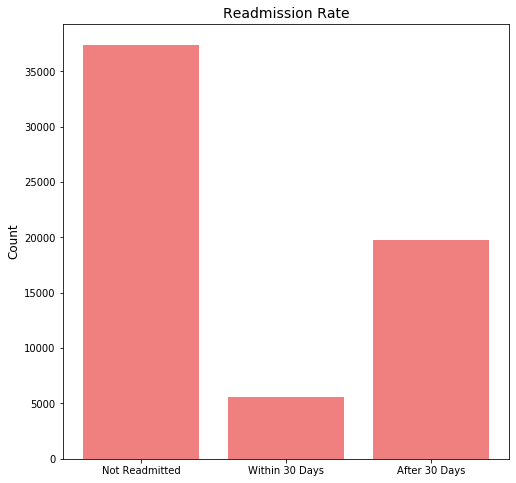

In [109]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='lightcoral')
plt.title('Readmission Rate', fontsize=14)
plt.ylabel('Count', fontsize=12)
# plt.savefig('Readmit_rate.png')
plt.show()

In [74]:
age_prct = pd.DataFrame(df.groupby(by = 'age')['readmitted'].value_counts())

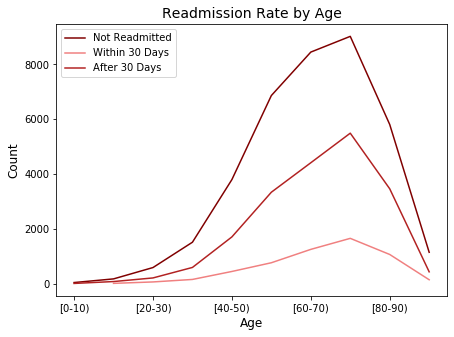

In [108]:
age_prct.unstack().plot(kind='line', color=['maroon', 'lightcoral', 'firebrick'], figsize=(7,5))
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Readmission Rate by Age', fontsize=14)
plt.legend(['Not Readmitted', 'Within 30 Days', 'After 30 Days'])
# plt.savefig('Readmit_vs_age.png')

In [13]:
race_prct = pd.DataFrame(df.groupby(by = 'race')['readmitted'].value_counts(normalize = True))

Text(0.5, 1.0, 'Readmission by Race')

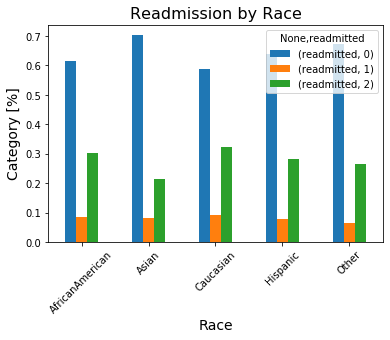

In [111]:
race_prct.unstack().plot(kind='bar')
plt.xlabel('Race', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Category [%]',fontsize=14)
plt.title('Readmission by Race', fontsize=16)

How many patients had diabetes as one of the top 3 diagnoses for inpatient visit?

In [146]:
print("Number of patients with diabetes as top3 diagnosis: ", 
      11495 + 8227 + 4559) # Yes, for diag3, diag2, diag1, respectively

Number of patients with diabetes as top3 diagnosis:  24281


In [133]:
print("Percent of inpatient visits with diabetes listed in top 3 diagnoses: ", 24281 / len(df) * 100)

Percent of inpatient visits with diabetes listed in top 3 diagnoses:  39.788611224907825


In [142]:
print("Percent of patients who received HbA1c test: ", len(df[df.A1C_test == 1]) / len(df) * 100)

Percent of patients who received HbA1c test:  18.55960671855797


In [145]:
print("Percent of patients who change meds after HbA1c tesT: ", 
      len(df[df.A1C_test_and_changed == 1]) / len(df[df.A1C_test == 1]))

Percent of patients who change meds after HbA1c tesT:  0.5580964153275649


## Feature Engineering

Was the patient given a A1C test at all?

In [113]:
df['A1C_test'] = np.where(df.A1Cresult == 'None', 0, 1)

Was the patient's meds changed during the hospitalization?

In [114]:
df.change = np.where(df.change == 'No', 0, 1)

Was the patient tested and meds changed?

In [115]:
df['A1C_test_and_changed'] = np.where((df.change == 1) & (df.A1C_test == 1), 1, 0)

From domain knowledge, patients are readmitted at different rates based on their age brackets.

In [116]:
conditions = [
    (df.age ==  '[0-10)') | (df.age == '[10-20)') | (df.age == '[20-30)'),
    (df.age == '[30-40)') | (df.age == '[40-50)') | (df.age == '[50-60)'),
    (df.age == '[60-70)') | (df.age == '[70-80)') | (df.age == '[80-90)') | (df.age == '[90-100')]

choices = [
    '[0-30)',
    '[30-60]',
    '[60-100)']

In [117]:
df['binned_age'] = np.select(conditions, choices, default=np.nan)

In [118]:
df = df[df.binned_age != 'nan']

In [119]:
df.drop(['age'], axis=1, inplace=True) # Dropping for correlation

/Users/arencarpenter/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Is diabetes one of the three primary diagnoses for the hospitalization?

In [120]:
df['diabetes_as_diag_1'] = np.where((df.diag_1 >= 250) & (df.diag_1 <251), 1, 0)
df['diabetes_as_diag_2'] = np.where((df.diag_2 >= 250) & (df.diag_2 <251), 1, 0)
df['diabetes_as_diag_3'] = np.where((df.diag_3 >= 250) & (df.diag_3 <251), 1, 0)

/Users/arencarpenter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/arencarpenter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/arencarpenter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [121]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True) # Dropping for correlation

In [122]:
meds_to_remove = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
            'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
            'metformin-rosiglitazone', 'metformin-pioglitazone']
df.drop(meds_to_remove, axis=1, inplace=True)

In [123]:
df.shape

(61025, 28)

## Feature Selection

In [156]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

### Generating Polynomical/Interaction Features

In [27]:
continuous_variables = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_variables = [x for x in X.columns if x not in continuous_variables]

In [28]:
df_cont = X[continuous_variables]
df_cate = X[categorical_variables]

Generating polynomial and interaction features for continuous variables.

In [29]:
poly_cont = PolynomialFeatures(2)
poly_df_cont_data = poly_cont.fit_transform(df_cont)
poly_df_cont_cols = poly_cont.get_feature_names(df_cont.columns)
poly_df_cont = pd.DataFrame(poly_df_cont_data, columns=poly_df_cont_cols) # 45 features

In [30]:
poly_df_cont.shape

(61025, 45)

Generating interaction features for categorical variables.

In [31]:
dummy_df_cate = pd.get_dummies(df_cate)

In [32]:
poly_cate = PolynomialFeatures(interaction_only=True)
poly_df_cate_data = poly_cate.fit_transform(dummy_df_cate)
poly_df_cate_cols = poly_cate.get_feature_names(dummy_df_cate.columns)
poly_df_cate = pd.DataFrame(poly_df_cate_data, columns=poly_df_cate_cols) # 1,036 features

In [33]:
poly_df_cate.shape

(61025, 1036)

Concatenating our cont and cate features back together.

In [34]:
df_all = pd.concat([poly_df_cont, poly_df_cate], axis = 1) # 1,081 features total

In [35]:
df_all.shape

(61025, 1081)

### Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_all, y, random_state=30)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (45768, 1081) Target:  (45768,)
Training set - Features:  (15257, 1081) Target:  (15257,)


Scaling our data: fit to the training set then apply to both train and test sets.

In [37]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

### Removing Correlated Features

In [38]:
corr_matrix = X_train.corr().abs()

In [39]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [155]:
correlated = [column for column in upper.columns if any(upper[column] > 0.75)]
print(len(correlated))
X_train.drop(columns=correlated, inplace=True)
X_test.drop(columns=correlated, inplace=True)

428


## Modeling

In [151]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}\n".format(f1_score(labels, preds, average='weighted')))

### Logistic Regression

In [44]:
logreg = LogisticRegressionCV(random_state=30, max_iter=1000)
model_log = logreg.fit(X_train, y_train)

In [149]:
y_pred = model_log.predict(X_test)
y_pred_train = model_log.predict(X_train)

In [152]:
print_metrics(y_pred, y_test)
print_metrics(y_pred_train, y_train)

Precision Score: 0.878476112823396
Recall Score: 0.6000524349478927
Accuracy Score: 0.6000524349478927
F1 Score: 0.6974500889102002

Precision Score: 0.8855551820076031
Recall Score: 0.6088751966439434
Accuracy Score: 0.6088751966439434
F1 Score: 0.7051051372857531



In [47]:
info = list(tuple(zip(X_train.columns, model_log.coef_[0])))
info.sort(key = lambda x: x[1]) 
top_20_pos = info[-20:]
top_20_neg = info[:20]

In [48]:
top_20_neg

[('number_inpatient', -0.1638442434818923),
 ('number_diagnoses', -0.10233336085419192),
 ('admission_source_id max_glu_serum_None', -0.08254081093691162),
 ('number_emergency', -0.07650544064795876),
 ('number_outpatient', -0.059371989527597056),
 ('time_in_hospital', -0.05603253101460419),
 ('discharge_disposition_id binned_age_[30-60]', -0.032153581466377666),
 ('num_procedures number_emergency', -0.030348182515057477),
 ('discharge_disposition_id diabetes_as_diag_1', -0.03021334118394899),
 ('discharge_disposition_id metformin_Steady', -0.02695735377818883),
 ('diabetesMed_Yes binned_age_[60-100)', -0.024465822619141313),
 ('discharge_disposition_id diabetes_as_diag_2', -0.024161714653949135),
 ('discharge_disposition_id race_Hispanic', -0.020522856407892493),
 ('admission_type_id A1C_test', -0.0204464187799277),
 ('diabetes_as_diag_3 glyburide_Up', -0.01994953877468457),
 ('gender_Female max_glu_serum_>300', -0.01948109098816026),
 ('diabetes_as_diag_1 diabetesMed_No', -0.01898905

In [49]:
top_20_pos

[('discharge_disposition_id max_glu_serum_>300', 0.016677242646306833),
 ('race_Hispanic metformin_Down', 0.01691198200640585),
 ('race_Other binned_age_[30-60]', 0.017104519729372984),
 ('diabetes_as_diag_1 metformin_Up', 0.017170707096908912),
 ('admission_type_id insulin_No', 0.017293165113632075),
 ('change race_Asian', 0.017651897229960526),
 ('insulin_No binned_age_[30-60]', 0.0176646950879493),
 ('race_Asian metformin_Steady', 0.01772189487066049),
 ('admission_source_id binned_age_[60-100)', 0.017912838879418604),
 ('diabetes_as_diag_1 race_AfricanAmerican', 0.01797871716997232),
 ('admission_type_id max_glu_serum_None', 0.01828047882318645),
 ('diabetes_as_diag_3 metformin_Steady', 0.019380333101187537),
 ('admission_source_id change', 0.019397825725268644),
 ('diabetes_as_diag_3 metformin_Up', 0.020870950494928382),
 ('glyburide_Steady binned_age_[30-60]', 0.022283443671238974),
 ('A1C_test diabetes_as_diag_1', 0.027364724279092572),
 ('number_outpatient^2', 0.028064394774789

#### GridSearch CV

In [ ]:
# logreg_grid = LogisticRegressionCV(random_state=30, max_iter=1000, n_jobs=-1)

# param_grid ={'Cs': [1, 10, 20], 
#             'cv': [1, 3, 5, 7]}

# #create the instance of GridSearchCV using the F1 metric for our scoring. 
# scorer = make_scorer(f1_score, average='weighted')
# logreg_grid=GridSearchCV(logreg_grid, param_grid, scoring=scorer, verbose=2, n_jobs=-1)

In [ ]:
# logreg_grid.fit(X_train,y_train)

In [ ]:
# y_pred = logreg_grid.best_estimator_.predict(X_test)

In [ ]:
# print("Best Parameter Combination Found During Grid Search:")
# logreg_grid.best_params_

In [ ]:
# print_metrics(y_test, y_pred)

#### Logistic Regression with SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2)
# X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [ ]:
# X_train_smote.shape

In [ ]:
# logreg = LogisticRegressionCV(random_state=30, max_iter=1000)
# model_log_smote = logreg.fit(X_train_smote, y_train_smote)

In [ ]:
# y_pred = model_log_smote.predict(X_test)

In [ ]:
# print_metrics(y_pred, y_test)

## Recursive Feature Elimination

In [50]:
# rfe_log = LogisticRegressionCV(random_state=30, max_iter=1000)

In [ ]:
# Instantiate a recursive eliminator object
# selector = RFECV(verbose=1, estimator=rfe_log, step=10, scoring='neg_mean_squared_error')

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [52]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]


In [ ]:
# len(list(removed_rfe)) # We eliminated 30 features from our model

In [ ]:
# list(selected_rfe) # Here are the features we are keeping

## No Interaction/Poly

In [159]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

In [160]:
continuous_variables = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_variables = [x for x in X.columns if x not in continuous_variables]

In [161]:
df_cont = X[continuous_variables]
df_cate = X[categorical_variables]

Generating interaction features for categorical variables.

In [162]:
dummy_df_cate = pd.get_dummies(df_cate)

In [163]:
dummy_df_cate.shape

(61025, 45)

Concatenating our cont and cate features back together.

In [164]:
df_all = pd.concat([df_cont, dummy_df_cate], axis = 1) # 1,081 features total

In [165]:
df_all.shape

(61025, 53)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df_all, y, random_state=30)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (45768, 53) Target:  (45768,)
Training set - Features:  (15257, 53) Target:  (15257,)


In [168]:
logreg_nopoly = LogisticRegressionCV(random_state=30, max_iter=1000)
model_log_nopoly = logreg_nopoly.fit(X_train, y_train)

In [169]:
y_pred = model_log_nopoly.predict(X_test)
y_pred_train = model_log_nopoly.predict(X_train)

In [170]:
print_metrics(y_pred, y_test)
print_metrics(y_pred_train, y_train)

Precision Score: 0.8988571301977448
Recall Score: 0.6024120076030675
Accuracy Score: 0.6024120076030675
F1 Score: 0.7061286748857043

Precision Score: 0.9008565140424825
Recall Score: 0.6040464953679426
Accuracy Score: 0.6040464953679426
F1 Score: 0.7085467267371703



In [171]:
info = list(tuple(zip(X_train.columns, model_log_nopoly.coef_[0])))
info.sort(key = lambda x: x[1]) 
top_20_pos = info[-20:]
top_20_neg = info[:20]

In [173]:
top_20_neg

[('number_inpatient', -0.31621343918891937),
 ('diabetes_as_diag_1', -0.17834608190837242),
 ('number_emergency', -0.16078122501822417),
 ('binned_age_[60-100)', -0.1381808105853099),
 ('diabetes_as_diag_2', -0.1307825051729614),
 ('race_Caucasian', -0.11194897438754858),
 ('diabetesMed_Yes', -0.11098870678672894),
 ('race_AfricanAmerican', -0.10238310563528479),
 ('glipizide_Down', -0.08885116440697861),
 ('metformin_No', -0.08784039522762499),
 ('diabetes_as_diag_3', -0.07289107330071935),
 ('max_glu_serum_>300', -0.0698933029001082),
 ('number_diagnoses', -0.06423018644702762),
 ('insulin_Down', -0.053305170124480404),
 ('A1Cresult_>8', -0.04662136475384914),
 ('number_outpatient', -0.03604285519706631),
 ('race_Hispanic', -0.03389975065589673),
 ('glyburide_Down', -0.024622109494838708),
 ('glyburide_Up', -0.02167160961069942),
 ('time_in_hospital', -0.021413110401647183)]

In [174]:
top_20_pos

[('max_glu_serum_Norm', 0.012494312203856668),
 ('max_glu_serum_>200', 0.01751228383247047),
 ('gender_Male', 0.017981130203118464),
 ('num_procedures', 0.018344605117772732),
 ('glipizide_Steady', 0.018748942101470652),
 ('change', 0.02331759036518468),
 ('A1C_test', 0.027976635106044898),
 ('binned_age_[30-60]', 0.031180295561993216),
 ('A1C_test_and_changed', 0.03543135542135606),
 ('max_glu_serum_None', 0.04725130046518724),
 ('metformin_Down', 0.04725932797788229),
 ('glyburide_No', 0.050421524552373365),
 ('metformin_Up', 0.052403089371223205),
 ('insulin_Steady', 0.06799209678998369),
 ('A1Cresult_Norm', 0.07698199883448394),
 ('race_Other', 0.0794314060273151),
 ('glipizide_No', 0.08414838351290775),
 ('binned_age_[0-30)', 0.11436510862479453),
 ('diabetesMed_No', 0.11835330038815163),
 ('race_Asian', 0.17616501825287456)]